# V8 Phase 1 v2: Epistemic Uncertainty for Unlearning Verification

**Memory-optimized version** - Uses single model throughout to avoid OOM.

---

In [1]:
!pip install -q transformers accelerate bitsandbytes datasets peft trl
!pip install -q scipy matplotlib seaborn

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Dict
from tqdm import tqdm
import gc
import warnings
warnings.filterwarnings('ignore')

print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

GPU: Tesla T4
GPU Memory: 15.8 GB


## 1. Uncertainty & Perplexity Measurement

In [3]:
@dataclass
class UncertaintyResult:
    prompt: str
    response: str
    mean_entropy: float
    first_token_entropy: float
    num_tokens: int

class TokenEntropyMeasurer:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.device = next(model.parameters()).device

    def measure(self, prompt: str, max_tokens: int = 30) -> UncertaintyResult:
        formatted = f"<s>[INST] {prompt} [/INST]"
        inputs = self.tokenizer(formatted, return_tensors="pt").to(self.device)
        prompt_len = inputs.input_ids.shape[1]

        generated_ids = inputs.input_ids.clone()
        entropies = []

        self.model.eval()
        for _ in range(max_tokens):
            with torch.no_grad():
                outputs = self.model(generated_ids)
                logits = outputs.logits[0, -1]
                probs = F.softmax(logits.float(), dim=-1)
                entropy = -torch.sum(probs * torch.log(probs + 1e-10)).item()
                entropies.append(entropy)

                next_token = torch.argmax(probs).unsqueeze(0).unsqueeze(0)
                generated_ids = torch.cat([generated_ids, next_token], dim=1)

                if next_token.item() == self.tokenizer.eos_token_id:
                    break

        response = self.tokenizer.decode(generated_ids[0, prompt_len:], skip_special_tokens=True)

        return UncertaintyResult(
            prompt=prompt, response=response,
            mean_entropy=np.mean(entropies) if entropies else 0.0,
            first_token_entropy=entropies[0] if entropies else 0.0,
            num_tokens=len(entropies),
        )

    def measure_batch(self, prompts: List[str], max_tokens: int = 30) -> List[UncertaintyResult]:
        return [self.measure(p, max_tokens) for p in tqdm(prompts, desc="Measuring UQ")]

def compute_perplexity(model, tokenizer, texts: List[str]) -> float:
    model.eval()
    total_loss, total_tokens = 0, 0
    device = next(model.parameters()).device

    with torch.no_grad():
        for text in texts[:15]:
            inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs, labels=inputs["input_ids"])
            total_loss += outputs.loss.item() * inputs["input_ids"].shape[1]
            total_tokens += inputs["input_ids"].shape[1]

    return np.exp(total_loss / total_tokens)

## 2. Load TOFU Dataset

In [4]:
from datasets import load_dataset

print("Loading TOFU...")
forget_data = load_dataset("locuslab/TOFU", "forget10")['train']
retain_data = load_dataset("locuslab/TOFU", "retain90")['train']

forget_questions = [item['question'] for item in forget_data]
retain_texts = [f"Q: {item['question']}\nA: {item['answer']}" for item in retain_data]

print(f"Forget: {len(forget_data)}, Retain: {len(retain_data)}")

Loading TOFU...
Forget: 400, Retain: 3600


## 3. Load Model (Single Instance)

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

print(f"Loading {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
)
print(f"Loaded! GPU mem: {torch.cuda.memory_allocated()/1e9:.2f} GB")

Loading mistralai/Mistral-7B-Instruct-v0.2...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded! GPU mem: 4.47 GB


## 4. Measure BASE Model (Before Any Training)

In [6]:
# IMPORTANT: Measure base uncertainty BEFORE adding LoRA
model.eval()
measurer = TokenEntropyMeasurer(model, tokenizer)

print("Measuring base model uncertainty...")
base_results = measurer.measure_batch(forget_questions[:25], max_tokens=25)
base_entropies = [r.mean_entropy for r in base_results]
base_ppl = compute_perplexity(model, tokenizer, retain_texts)

print(f"\nBase Model:")
print(f"  Entropy: {np.mean(base_entropies):.3f}")
print(f"  Perplexity: {base_ppl:.2f}")

Measuring base model uncertainty...


Measuring UQ: 100%|██████████| 25/25 [02:10<00:00,  5.22s/it]



Base Model:
  Entropy: 0.465
  Perplexity: 18.00


In [7]:
# Check base model responses
print("Base model sample responses:")
for i in range(2):
    print(f"\nQ: {base_results[i].prompt}")
    print(f"A: {base_results[i].response[:120]}...")
    print(f"Entropy: {base_results[i].mean_entropy:.3f}")

Base model sample responses:

Q: What is the full name of the author born in Taipei, Taiwan on 05/11/1991 who writes in the genre of leadership?
A: The author you are referring to is Edwin Chan. His full name is Edwin Chang-Yu Chan...
Entropy: 1.030

Q: What does Hsiao Yun-Hwa identify as in terms of gender?
A: Hsiao Yun-Hwa is a Taiwanese actress and singer. She identifies as female....
Entropy: 0.394


## 5. Add LoRA and Fine-tune

In [8]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

# Add LoRA to the SAME model
model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 3,407,872 || all params: 7,245,139,968 || trainable%: 0.0470


In [9]:
# Prepare data
def format_sample(ex):
    return {"text": f"<s>[INST] {ex['question']} [/INST] {ex['answer']}</s>"}

train_data = forget_data.map(format_sample)
tokenized = train_data.map(
    lambda x: tokenizer(x["text"], truncation=True, max_length=256, padding="max_length"),
    batched=True, remove_columns=train_data.column_names
)
print(f"Training samples: {len(tokenized)}")

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Training samples: 400


In [10]:
# Fine-tune
training_args = TrainingArguments(
    output_dir="./ft",
    num_train_epochs=2,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    learning_rate=1e-4,
    fp16=True,
    logging_steps=20,
    save_strategy="no",
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized,
    data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False),
)

print("Fine-tuning...")
trainer.train()
print("Done!")

Fine-tuning...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
20,3.677000
40,2.650100


Done!


In [11]:
# Measure fine-tuned model
model.eval()
measurer = TokenEntropyMeasurer(model, tokenizer)
ft_results = measurer.measure_batch(forget_questions[:25], max_tokens=25)
ft_entropies = [r.mean_entropy for r in ft_results]
ft_ppl = compute_perplexity(model, tokenizer, retain_texts)

print(f"\nFine-tuned Model:")
print(f"  Entropy: {np.mean(ft_entropies):.3f} (was {np.mean(base_entropies):.3f})")
print(f"  Perplexity: {ft_ppl:.2f} (was {base_ppl:.2f})")

Measuring UQ: 100%|██████████| 25/25 [01:55<00:00,  4.61s/it]



Fine-tuned Model:
  Entropy: 1.140 (was 0.465)
  Perplexity: 7.82 (was 18.00)


## 6. Gradual Unlearning with Monitoring

In [12]:
def gradual_unlearn(model, tokenizer, forget_data, retain_texts,
                    num_steps=12, lr=5e-6, batch_size=30, max_ppl_ratio=2.5):
    """
    Gradual unlearning with perplexity monitoring.
    Stops early if model starts collapsing.
    """
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    forget_texts = [f"<s>[INST] {x['question']} [/INST] {x['answer']}</s>" for x in forget_data]

    # Baseline
    model.eval()
    baseline_ppl = compute_perplexity(model, tokenizer, retain_texts)
    max_ppl = baseline_ppl * max_ppl_ratio

    trajectory = {'step': [0], 'loss': [0], 'ppl': [baseline_ppl]}

    print(f"Baseline PPL: {baseline_ppl:.2f}, Max allowed: {max_ppl:.2f}")

    for step in range(1, num_steps + 1):
        model.train()
        indices = np.random.choice(len(forget_texts), min(batch_size, len(forget_texts)), replace=False)
        step_loss = 0

        for idx in indices:
            inputs = tokenizer(forget_texts[idx], return_tensors="pt", truncation=True, max_length=256)
            inputs = {k: v.to(model.device) for k, v in inputs.items()}

            outputs = model(**inputs, labels=inputs["input_ids"])
            (-outputs.loss).backward()  # Gradient ASCENT
            optimizer.step()
            optimizer.zero_grad()
            step_loss += outputs.loss.item()

        avg_loss = step_loss / len(indices)

        # Check health
        model.eval()
        current_ppl = compute_perplexity(model, tokenizer, retain_texts)

        trajectory['step'].append(step)
        trajectory['loss'].append(avg_loss)
        trajectory['ppl'].append(current_ppl)

        print(f"Step {step}: Loss={avg_loss:.1f}, PPL={current_ppl:.1f}")

        if current_ppl > max_ppl:
            print(f"\n[STOP] PPL {current_ppl:.1f} > {max_ppl:.1f} - stopping before collapse")
            break

    model.eval()
    return model, trajectory

In [13]:
# Run gradual unlearning
model, trajectory = gradual_unlearn(
    model, tokenizer, list(forget_data), retain_texts,
    num_steps=12, lr=5e-6, batch_size=30, max_ppl_ratio=2.5
)

Baseline PPL: 7.82, Max allowed: 19.54
Step 1: Loss=2.4, PPL=7.9
Step 2: Loss=2.4, PPL=8.0
Step 3: Loss=2.8, PPL=8.1
Step 4: Loss=2.8, PPL=8.2
Step 5: Loss=3.2, PPL=8.3
Step 6: Loss=3.2, PPL=8.4
Step 7: Loss=3.6, PPL=8.5
Step 8: Loss=3.4, PPL=8.7
Step 9: Loss=4.2, PPL=9.2
Step 10: Loss=8.3, PPL=28.3

[STOP] PPL 28.3 > 19.5 - stopping before collapse


## 7. Final Measurements

In [14]:
# Measure unlearned model
model.eval()
measurer = TokenEntropyMeasurer(model, tokenizer)
ul_results = measurer.measure_batch(forget_questions[:25], max_tokens=25)
ul_entropies = [r.mean_entropy for r in ul_results]
ul_ppl = compute_perplexity(model, tokenizer, retain_texts)

# Compute UR
ur = np.mean(ul_entropies) / np.mean(base_entropies) if np.mean(base_entropies) > 0 else 0

print("=" * 55)
print("FINAL RESULTS")
print("=" * 55)
print(f"{'Model':<18} {'Entropy':<10} {'Perplexity':<10}")
print("-" * 40)
print(f"{'Base':<18} {np.mean(base_entropies):<10.3f} {base_ppl:<10.1f}")
print(f"{'Fine-tuned':<18} {np.mean(ft_entropies):<10.3f} {ft_ppl:<10.1f}")
print(f"{'Unlearned':<18} {np.mean(ul_entropies):<10.3f} {ul_ppl:<10.1f}")
print(f"\nUncertainty Ratio: {ur:.3f}")

Measuring UQ: 100%|██████████| 25/25 [02:03<00:00,  4.95s/it]


FINAL RESULTS
Model              Entropy    Perplexity
----------------------------------------
Base               0.465      18.0      
Fine-tuned         1.140      7.8       
Unlearned          0.002      28.3      

Uncertainty Ratio: 0.005


In [15]:
# Interpretation
print("\n" + "=" * 55)
print("INTERPRETATION")
print("=" * 55)

if np.mean(ul_entropies) < 0.01:
    print("[COLLAPSED] Model outputs garbage")
elif ur < 0.7:
    print(f"[HIDING] UR={ur:.3f} < 0.7")
    print("Knowledge likely still present but suppressed")
elif ur < 1.0:
    print(f"[PARTIAL] UR={ur:.3f}")
    print("Approaching base uncertainty - some knowledge may remain")
else:
    print(f"[CANDIDATE] UR={ur:.3f} >= 1.0")
    print("Uncertainty matches base - possible true unlearning")


INTERPRETATION
[COLLAPSED] Model outputs garbage


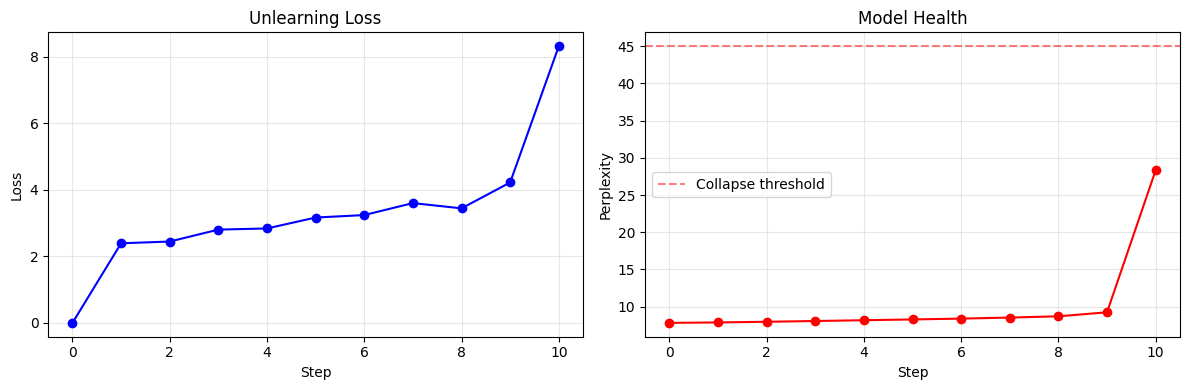

In [16]:
# Plot trajectory
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(trajectory['step'], trajectory['loss'], 'b-o')
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_title('Unlearning Loss')
ax1.grid(True, alpha=0.3)

ax2.plot(trajectory['step'], trajectory['ppl'], 'r-o')
ax2.axhline(base_ppl * 2.5, color='r', linestyle='--', alpha=0.5, label='Collapse threshold')
ax2.set_xlabel('Step')
ax2.set_ylabel('Perplexity')
ax2.set_title('Model Health')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('trajectory.png', dpi=150)
plt.show()

In [17]:
# Sample responses
print("\nSAMPLE RESPONSES")
print("=" * 60)
for i in range(2):
    print(f"\nQ: {base_results[i].prompt}")
    print(f"Base ({base_results[i].mean_entropy:.2f}): {base_results[i].response[:80]}")
    print(f"FT ({ft_results[i].mean_entropy:.2f}): {ft_results[i].response[:80]}")
    print(f"UL ({ul_results[i].mean_entropy:.2f}): {ul_results[i].response[:80]}")


SAMPLE RESPONSES

Q: What is the full name of the author born in Taipei, Taiwan on 05/11/1991 who writes in the genre of leadership?
Base (1.03): The author you are referring to is Edwin Chan. His full name is Edwin Chang-Yu C
FT (1.61): The author's full name is Chih-Yu Chen.
UL (0.00): [ [ [ [ [ [ [ [ [ [ [ [ [ [ [ [ [ [ [ [ [ [ [ [ [

Q: What does Hsiao Yun-Hwa identify as in terms of gender?
Base (0.39): Hsiao Yun-Hwa is a Taiwanese actress and singer. She identifies as female.
FT (0.40): Hsiao Yun-Hwa identifies as a woman.
UL (0.00): [ [ [ [ [ [ [ [ [ [ [ [ [ [ [ [ [ [ [ [ [ [ [ [ [


In [18]:
# Save results
import json
results = {
    "base_entropy": float(np.mean(base_entropies)),
    "ft_entropy": float(np.mean(ft_entropies)),
    "ul_entropy": float(np.mean(ul_entropies)),
    "uncertainty_ratio": float(ur),
    "base_ppl": float(base_ppl),
    "ul_ppl": float(ul_ppl),
    "steps_taken": len(trajectory['step']) - 1,
}
with open("results.json", "w") as f:
    json.dump(results, f, indent=2)
print("Saved to results.json")

Saved to results.json
